# Lab 4: Hit-Talk Project, Week 1 of 3 Report
Your name: Alejandro Alfaro

As discussed in class, we have an extended project starting this week that will use all of your CircuitPython and Jupyter notebook skills, including the new topic for this week (and HW4) of Dictionaries in Python.

The task for this week will be to get experience with 

1. Making your Itsy Bitsy Autonomous (battery pack, tape)
2. Practicing recording air punches in one axis at a time, and looking at the signal
3. Practice processing the signal
   1. Remove offset 
   2. Get magnitude so you don't care about sign of acceleration   
   3. Threshold    
   4. Find peaks and output detected axis

In [ ]:

#np_var1[np_var1<3] = 0

## Hardware setup

Several steps are needed to prepare your board for today's lab. They are listed in the checklist below:

- [x] You should have your `boot.py` saved to your Itsy Bitsy. Use the version you used for lab 2 or 3. Remember the pin you set in `boot.py` for switching between USB write/read versus Itsy Bitsy data logging mode
- [x] Prepare a button for use as your input signal for controlling USB RW vs data logging mode, and remember the pin you used (should be one of the `Dx` pins). Later you will test that this is operating correctly.
- [x] Prepare your neopixel or dotstar (only one is needed) and make sure they are properly connected
- [x] Obtain battery pack from TA. Connect your battery pack to the board, connect negative (black wire) to `Ground` and positive (red wire) to `5V (USB)`.
- [x] Put the batteries in the battery pack, disconnect the USB cable, and switch the battery on to test whether the connection is correct. If the light is not on after you switch the power on, immediately switch off the power to avoid possible damage and check your connection.
- [x] Use tape to affix the battery pack to you board. Make sure you leave the side with the switch in a position so you can easily get access to it.
- [x] To enhance the robustness of the signal detection, reconfigure your accelerometer to use `9g` mode instead of `3g`. To do this, find the `GSEL` pin on your accelerometer and connect it to `VDD` (3.3V, never connect it to 5V!).
    <img src='imgs/board.png' width="200">
    <center> <b>Figure 1. Connect GSEL to VDD to switch to 9g mode</b> </center>

## Principle axis of motion detection

In week 1, you need to be prepared to work on the basics of motion data acquisition and analysis for the upcoming week 2 and 3. We will provide you the CircuitPython code that allow you to record accelerations in three axes simutaneously for a variable length of time. Please carefully read the Jupyter notebook material below for an overview of what you are going to do in this week's lab. Then we will give you the detailed TO-DO list for you to complete after the [Import libraries](#Import-libraries-and-define-helper-functions) section.

We define the **principle axis of any motion as the axis on which the maximum magnitude of acceleration is detected**. If you quickly shake your accelerometer (roughly) in the direction of the `Y` axis and take measurements on all the three axes, you will see a big spike in the `Y` axis and smaller spikes (due to imperfect direction of movement) on the other two axes. Note that whenever we talk about the "scale" of acceleration, we are referring to the absolute value of acceleration, *e.g.* an acceleration of plus or minus `1g` both the same scale of `1g`.

<img src='./imgs/board_axes.png' width="200">
<center> <b>Figure 2. Three measurement axes of the accelerometer: if you hold your chip in front of you on your protoboard such that you see what is in this picture, X+ is up, Y+ is to your right, and Z+ is outward.</b> </center>

For the sake of consistency, you should hold your board such that the long axis is vertical. It should looks like this:

<img src='./imgs/reference_grip.png' width="400">
<center> <b>Figure 3. Always hold your board in this way when taking measurements.</b> </center>

when holding the board in such pose, the motion by which to activate each axis can be done in the following fashion:
<img src='./imgs/axes_motion.gif' width="200">
<center> <b>Figure 4. Direction of motion to activate each axis.</b> </center>

Remember, we only care about the scale of acceleration, so it does not matter if you go in the plus or minus Y direction for example.

### Data analysis and the peak finding algorithm
As an example, a straight "punch-like" motion in the direction of `Y` axis will create an acceleration profile like this:
<img src='./imgs/spike_raw_calib.png' width="800">
<center> <b>Figure 5. A) Baseline with no motion. B) Absolute acceleration of three air punches in the direction of Y, X, and Z</b> </center>

Note that the unit needs to be converted to acceleration.

#### Calibrating the baseline
Depending on the orientation of your initial pose while holding the board on your hand, the baseline of your measurement could be very different. Note in Figure 5B that axis X starts with a near `1g` acceleration and that none of the three axes starts with zero acceleration. Taking the data without removing this baseline will likely produce incorrect results. Since we only care about the motion with respect with the reference pose - holding the board stationary - we need to take a separate measurement during the reference pose and subtract the baseline for all three axes.

<img src='./imgs/spike_xyz_calibrated.png' width="800">
<center> <b>Figure 6. A) Data shown in Figure 5B after offsetting baseline. B) The first peak shown in A after thresholding by 1g</b> </center>


#### Dealing with noise

From our perspective, any signal that is not what we are interested in is a form of **noise**. There are different kinds of noises in the process of our measurement:
- **ADC noise.** ADC noise comes from both hardware and sofrware. It is somewhat predictable and comes from two sources.
    1. Power source contamination. Our supply voltage is not a perfect DC voltage and might contains other waveforms. For example, when you pluged your laptop to the AC and connected your board through the USB port, the USB supply voltage (5V DC) will be contaminated by the 50Hz AC signal.
    2. Numerical precision. Remember your ADC has a 12-bit resolution on the hardware side, and that CircuitPython abstracted it to a 16-bit integer? That means (theoreticaly) in worst case, your measurements could be off by at most $3.3 * 1 / (2^{12}-1)$ volts.
- **Process noise.** Process noise prepresents all of the irrelevant process that inevitably involved and influences our measurements. Things like the tiny spontaneous shake of your hand, mis-aligned measurement axes, and even the inertial property of your accelerometer are all good examples of process noise. They are almost impossible to exactly predict, but we could summarize them as contributing to a fixed noise floor (by modeling them by a zero-mean Gaussian distribution).

We use a fixed noise floor to denote the contribution from all noises. This means we are simply throwing out all the small  acceleration values after having removed the baseline. To do so, we use a process called **"Thresholding"** where you set all the measurements below a certain amount to zero and leave the rest as is. Typically, no noise is going to be bigger than `1g`, hence, starting with `1g` is a good choice. This rather crude model of noise works well in our case because the signal we are measuring (a spike) is large with respect to the noise (high signal to noise ratio, or "SNR").

Finally, an example dataset before and after all the preprocessing is shown below:
<img src='./imgs/data_before_after.png' width="800">
<center> <b>Figure 7. A) Raw data before any preprocessing. B) After removing baseline, taking the absolute value, and thresholding. </b> </center>


#### Find peaks and figure out the principle axis of motion

There is only one critical problem to solve now. Given the processed data, how do we identify the principle axis of motion? To figure out a reliable algorithm, we need to ask ourself, how did we do it ourselves? Our brain seems to be handling this problem easily and reliably, so let's try to summarize what we did (at least one possible mechanism):

- first we scan through the plot in Figure 6A from left to right. We saw a three groups of peaks and within each group, a highest peak.
- then we try to find which color the highest peak in each group is and remember the colors
- finally we read the captions and find out the axis label of each color and now we know the sequence

Similarly, following the same intuition of the above procedure, we can summarize it into an algorithm:

1. Given input `x, y, z` which correspond to the preprocessed acceleration measurements in the three axes
2. Call `find_peaks` function to return all the peaks for each axis that are higher than a certain amount (say `3g`). The indices of where the peaks are is saved to `x_pks_idx, y_pks_idx, z_pks_idx` with their height saved to `x_pks, y_pks, z_pks`, respectively. Chances are, data like Figure 6B where you see two very close consecutive peaks in the actual principle axis will show up. You can deal with this by setting an appropriate minimal distance between two peaks argument (`distance`) in the `find_peaks` function. This is detailed in [part 3](#Find-peaks-and-identify-the-principle-axis-of-motion) below.
3. Loop through the peaks in `x_pks, y_pks, z_pks`, sort by the index of the peaks (such that the peaks appears chronologically).
4. Look up the axis label each peaks belongs to and return the peak sequence string.

### Understand the CircuitPython code
The entire CircuitPython code you will be using today is provided in the [appendix](#Source-code-of-main.py).

Now, **retrieve the printout of main.py we gave you** and, before reading through it carefully, please read the basic function description summarized here:

- Initialized three measurement axes of the accelerometer to use pin `A1~A3` AnalogIn channels (change as needed).
- Initialized button input to use pin `D9` (change as needed).
- Starting from the Main Loop section, the code does the following things:
    1. if `debug_mode` is set to `True`, then the program will skip all following steps and take continuous measurements and print to serial so you can look at the data in the Plotter.
    
    2. if `debug_mode` is `False`, then the board will first check if write mode is enabled (by setting the readonly pin specified in `boot.py` to ground) through the following code:
    ```python
    blink_color = COLOR_GRAY
    try:
            with open("test.txt", "w") as fp:
                fp.close()
    except:
            blink_color = COLOR_RED    
    ```
    when opening dummy file `test.txt` for writing works, the `blink_color` is set to `COLOR_GRAY`; otherwise the color will be `COLOR_RED`. When you power on your board and see the neopixel/dotstar blinks red, then it means you have not entered the writing mode, so double check your connection.
    Once you see the neopixel/dotstar blinks gray, you know you have write permission and can proceed to the next step.
    
    3. The code runs on your board in the following way: if you switch the board on and hold your board in the reference grip as illustrated in previous sections, your neopixel/dotstar will start blinking until you press the button for the first time: then it stops blinking for 1 second and then turns solid green indicating that it's recording one second of data for establishing the baseline. You will want to hold your board steady when it's measuring the baseline data (neopixel/dotstar is in solid green). 
    
    **NEVER TURN OFF OR RESET BOARD WHEN THE LIGHT IS GREEN. You can do so when the board is not writing data (neopixel/dotstar will be in non-green color).** Doing so will either break your board or cause it to erase all files in the drive.
    
    After about 1 second of measurement, the neopixel/dotstar will turn back to solid gray, which indicates idling. The reference data will always be named `measurements_00.txt` in your CircuitPython drive.
    
    4. Once you have taken the baseline data, the program will enter an infinite loop and listen to the button input. In this setting, you can click the button again to start a new measurement (neopixel/dotstar turns green) and press it again to end the session (neopixel/dotstar turns back to gray) and write to file. You can do this as many time as you want and every new measurement will have a new filename starting at `measurements_01.txt, measurements_02.txt` and so on. Make sure you note down what each file is recording. And again, DO NOT turn off or reset your board when it's writing data (neopixel/dotstar is green). Turn off only when it is idling (neopixel/dotstar is gray).

## Import libraries and define helper functions

In [39]:
import numpy as np
from scipy.signal import find_peaks
from statistics import mean, stdev
# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Helper function to unpack measurement file
def unpack_data(filename='data.txt'):
    '''unpack_data unpacks measurements and output each column
    
    INPUT:
        filename (str): path to data file to unpack
        
    OUTPUT:
        tuple of all unpacked columns as numpy array
        
    EXAMPLE:
        time_list, temp_list = unpack_data(filename='temperature.txt')             # data file with 2 columns
        time_list, xaxis, yaxis, zaxis = unpack_data(filename='accelerometer.txt') # data file with 4 columns
    '''
    # read file and convert units
    with open(filename, 'r') as file:
        temps = file.read()
    measurements = [m.split(',') for m in temps.split('\n') if len(m) > 2]
    # unpack values and assemble a tuple for output
    # note that the following code assumes you have followed the guideline to put
    # time as the first value in the measurement list
    #
    # process time column
    time_list = [float(m[0]) for m in measurements]
    # Remove initial time offset to make time starts from 0
    time_list = [val-time_list[0] for val in time_list]
    # loop through all remaining columns
    out_tuple = (np.array(time_list),)
    for idx in range(1, len(measurements[0])):
        data_list = np.array([float(m[idx]) for m in measurements])
        out_tuple += (data_list,)
    return out_tuple

# Helper function to convert between voltage and raw ADC unit
'''unpack_data unpacks measurements and output each column
    
    INPUT:
        x (numpy array): array of raw measurements to convert unit from
        
    OUTPUT:
        numpy array with all elemented converted to either 16bit integer or voltage unit
        
    EXAMPLE:
        adc_to_volt(x_list) # convert measured x axis raw ADC values to voltage unit
    '''
def _adc_to_volt(val): return float(3.3 * val / 65535) # base fucntion, don't call this directly to numpy list
def _volt_to_adc(val): return int(65535 * val / 3.3)   # base function, don't call this directly to numpy list
def _adc_to_acceleration(val): return float( (_adc_to_volt(val) - 3.3/2) / 0.1178) # sensitivity is 117.8mV/g, don't call this directly to numpy list
# Call the following functions
adc_to_volt = np.vectorize(_adc_to_volt) # ready-to-use vectorized function
volt_to_adc = np.vectorize(_volt_to_adc) # ready-to-use vectorized function
adc_to_acceleration = np.vectorize(_adc_to_acceleration) # ready-to-use vectorized function
'''
EXAMPLE:
    adc_to_volt(12345)    # return array(0.62162966) in voltage unit
    volt_to_adc(0.62163)  # return array(12345) in ADC unit (16bit integer)
    adc_to_acceleration(40000) # return array(3.09160348) in acceleration
''';

## Start your work here

Below you can find detailed instructions for each part of the experiment. In summary, your main task is to record three measurement sessions (in three separate text files in addition to the reference baseline file) during which you will execute an air punch in the direction of each of the three measurement axes. Each file will have three air punches but in a different order. This means you could air punch the three axes in the order of `XYZ` in the first session (punch `X` axis first, wait for at least 0.5 second, then `Y`, and finally `Z` axis), `YZX` in the second session (a new file), and `ZYX` in the third session (a new file). 

Note that you don't have to follow this exact order. You are asked to do three different orders. They can be any permutation of `XYZ` as long as the three sessions are different and you don't reuse any axis (`YYX` for example is not accepted since `Z` axis is not used).

Use your baseline measurement for part 1 below.

Use any one of your three measurement files for [part 2](#Part-2---Prepare-measurement-data-for-analysis) to demonstrate and visualize the your data preprocessing.

All three measurement files will eventually be used in [part 3](#Find-peaks-and-identify-the-principle-axis-of-motion) where you will demonstrate your algorithm for figuring out the sequence of peaks on one of your datasets. Then you need to put your algorithm into a function and call the same function for the other two datasets to make sure your algorithm works not only on your initial dataset, but any similar dataset.

### Hints on how to use matplotlib

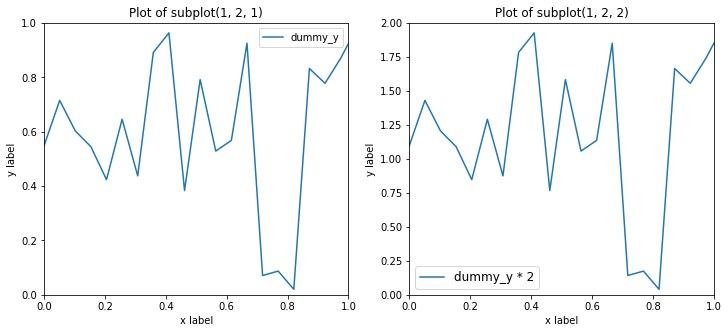

In [22]:
# create dummy data for plot
np.random.seed(0)
dummy_x = np.linspace(0, 2, 40)
dummy_y = np.random.rand(40)


plt.figure(figsize=[12,5]) # create a new figure of size 12x8

# first subplot
plt.subplot(1, 2, 1) # create a 1x2 subplot grid and use the first subplot
plt.plot(dummy_x, dummy_y, label='dummy_y')
plt.xlabel('x label')
plt.ylabel('y label')
plt.title('Plot of subplot(1, 2, 1)')
plt.xlim([0, 1]) # use this to control the display range of x
plt.ylim([0, 1]) # use this to control the display range of y
plt.legend(fontsize=10) # show legend
# second subplot
plt.subplot(1, 2, 2) # use the second subplot
plt.plot(dummy_x, dummy_y*2, label='dummy_y * 2')
plt.xlabel('x label')
plt.ylabel('y label')
plt.title('Plot of subplot(1, 2, 2)')
plt.xlim([0, 1]) # use this to control the display range of x
plt.ylim([0, 2]) # use this to control the display range of y
plt.legend(fontsize=12); # show legend

### Hints on how to use find_peaks

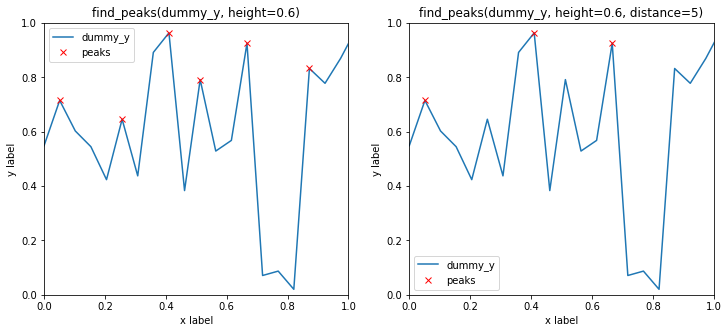

In [77]:
# call find peaks function
dummy_pks_idx, dummy_pks = find_peaks(dummy_y, height=0.6)
dummy_pks = dummy_pks['peak_heights']

plt.figure(figsize=[12,5]) # create a new figure of size 12x8
# first subplot
plt.subplot(1, 2, 1) # create a 1x2 subplot grid and use the first subplot
plt.plot(dummy_x, dummy_y, label='dummy_y')
plt.plot(dummy_x[dummy_pks_idx], dummy_y[dummy_pks_idx], 'rx', label='peaks') # show peaks as red x
plt.xlabel('x label')
plt.ylabel('y label')
plt.title('find_peaks(dummy_y, height=0.6)')
plt.xlim([0, 1]) # use this to control the display range of x
plt.ylim([0, 1]) # use this to control the display range of y
plt.legend(fontsize=10) # show legend

'''
as you can see, this will find and return all the peaksthat are higher than 0.6
'''

# call find peaks function
dummy_pks_idx, dummy_pks = find_peaks(dummy_y, height=0.6, distance=5)
dummy_pks = dummy_pks['peak_heights']
# second subplot
plt.subplot(1, 2, 2) # create a 1x2 subplot grid and use the first subplot
plt.plot(dummy_x, dummy_y, label='dummy_y')
plt.plot(dummy_x[dummy_pks_idx], dummy_y[dummy_pks_idx], 'rx', label='peaks') # show peaks as red x
plt.xlabel('x label')
plt.ylabel('y label')
plt.title('find_peaks(dummy_y, height=0.6, distance=5)')
plt.xlim([0, 1]) # use this to control the display range of x
plt.ylim([0, 1]) # use this to control the display range of y
plt.legend(fontsize=10) # show legend

'''
if we set an additional argument distance=5 in the find_peaks function,
then it will ignore lower peaks that are closer than {distance} together 
in their index. This is very helpful when you are trying to remove multiple
peaks are very close to each other and only get the highest one
''';

### Hints on sorting

In [4]:
# here's an dummy numpy
dummy_np_array = np.array([2,3,6,5,3,7,9,7,3,2,5])
# sort
dummy_np_array.sort()
print(dummy_np_array)

# here's the same sorting operation on a normal list
dummy_list = [2,3,6,5,3,7,9,7,3,2,5]
dummy_list = sorted(dummy_list)
print(dummy_list)

# sort the keys of a dictionary and return the items
dummy_dict = {
    3: 'a',
    1: 'b',
    4: 'c',
    2: 'd'
}
items = ''
for key in sorted(dummy_dict.keys()):
    items += dummy_dict[key]
print(items)

[2 2 3 3 3 5 5 6 7 7 9]
[2, 2, 3, 3, 3, 5, 5, 6, 7, 7, 9]
bdac


### Part 1 - Establish baseline
- [x] Record baseline data
- [x] Import your baseline data
- [x] Convert the units
- [ ] Plot the raw data (all three axes in one plot)
- [ ] Compute the baseline for each axis for the next session

Baseline for the x-axis is -0.823245
Baseline for the y-axis is 0.187270
Baseline for the z-axis is -0.194708


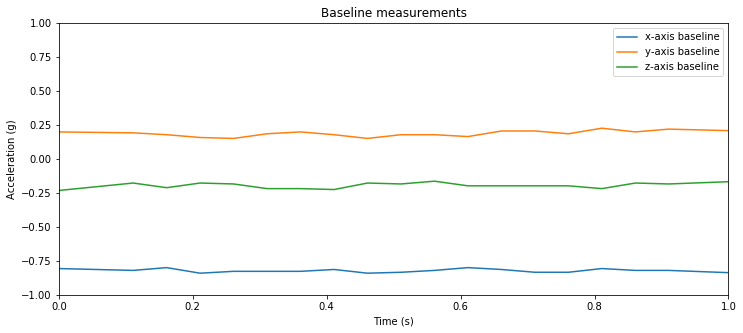

In [78]:
# Load baseline data
t_list,x_list,y_list,z_list = unpack_data(filename='baseline.txt')
# Convert the units to acceleration
baselineX_g = adc_to_acceleration(x_list)
baselineY_g = adc_to_acceleration(y_list)
baselineZ_g = adc_to_acceleration(z_list)

# Plot raw data
plt.figure(figsize=[12,5])


plt.plot(t_list, baselineX_g, label='x-axis baseline')
plt.plot(t_list, baselineY_g, label='y-axis baseline')
plt.plot(t_list, baselineZ_g, label='z-axis baseline')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Baseline measurements')
plt.xlim([0, 1]) 
plt.ylim([-1, 1])
plt.legend(fontsize=10)

# Compute baseline 
baselineX = mean(baselineX_g)
baselineY = mean(baselineY_g)
baselineZ = mean(baselineZ_g)

print(f'Baseline for the x-axis is {baselineX:2f}')
print(f'Baseline for the y-axis is {baselineY:2f}')
print(f'Baseline for the z-axis is {baselineZ:2f}')

### Part 2 - Prepare measurement data for analysis
- [ ] Load measurement data
- [ ] Convert the units to acceleration
- [ ] Process the measurement data to remove baseline, convert to absolute value, and threshold the noise floor
- [ ] Visualize raw and pre-processed data

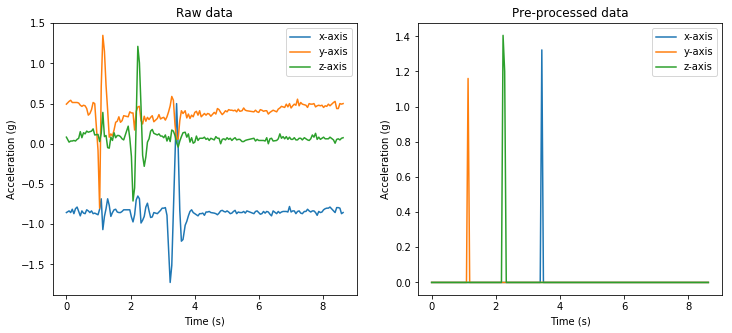

In [151]:
## load measurement data
t1_list,x1_list,y1_list,z1_list = unpack_data(filename='trial1.txt')
t2_list,x2_list,y2_list,z2_list = unpack_data(filename='trial2.txt')
t3_list,x3_list,y3_list,z3_list = unpack_data(filename='trial3.txt')

## Pre-process
# 1. Convert the unit to acceleration
rawX_g = adc_to_acceleration(x1_list)
rawY_g = adc_to_acceleration(y1_list)
rawZ_g = adc_to_acceleration(z1_list)
# 2. offset by the baseline and take the absolute value
X_g = abs(rawX_g - baselineX)
Y_g = abs(rawY_g - baselineY)
Z_g = abs(rawZ_g - baselineZ)

# 3. threshold the noise floor
X_g[X_g<1] = 0
Y_g[Y_g<1] = 0
Z_g[Z_g<1] = 0
#print(X_g)
## Visualize

# 1. Plot raw data in subplot(1, 2, 1)
plt.figure(figsize=[12,5])

plt.subplot(1, 2, 1)
plt.plot(t1_list, rawX_g, label='x-axis')
plt.plot(t1_list, rawY_g, label='y-axis')
plt.plot(t1_list, rawZ_g, label='z-axis')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Raw data')
#plt.ylim([-1, 1])
plt.legend(fontsize=10)

# 2. Plot pre-processed data in subplot(1, 2, 2)
plt.subplot(1, 2, 2)
plt.plot(t1_list, X_g, label='x-axis')
plt.plot(t1_list, Y_g, label='y-axis')
plt.plot(t1_list, Z_g, label='z-axis')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Pre-processed data')
#plt.ylim([-1, 1])
plt.legend(fontsize=10)



### Part 3 - Find peaks and identify the principle axis of motion
One you have the preprocessed data, the final thing to do is to use the find peaks algorithm and use the peaks to figure out the sequence of principle axes appeared in the data. For example, if a data contains measurements of three air punches in the axis sequence of `XYZ`, then your algorithm should return string `'XYZ'`.

- [ ] Practice and understand what the `find_peaks` function does (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)
- [ ] Find and get all peaks that are higher than a threshold (we are talking about a different threshold now, don't confuse it with the threshold we set earlier for filtering out noise). Plot the peaks with the preprocessed data (mark the peaks using `x`).
- [ ] Implement the algorithm introduced in the [find peaks section](#Find-peaks-and-figure-out-the-principle-axis-of-motion) in a function
- [ ] Test the result of your implemented function in your datasets and show the result

In [166]:
def identify_axes(x, y, z, h):
    '''
    This function takes the input x, y, z - the three numpy array
    of measurements in the x, y, and z axis respectively.
    
    The last input h (1x3 list) specifies the minimum height of 
    the peaks in the three axis separately (used in the find_peaks function call)
    
    OUTPUT:
        string representing detected order of activation, e.g. 'XYZ'
    
    EXAMPLE:
        identify_axes(x, y, z, [3, 3, 3]) # returns a string, e.g. 'XYZ'
    '''
    # 1. find peaks in the preprocessed x, y, and z measurement lists
    #    Use the input peak height list h and set an appropriate distance so 
    #    the returned peaks are correct and reliable.
    #    Take the advantage of the h argument. Set it for each axes such that only the 
    #    highest peaks will be found.
    #
    #    Adjust your parameters, especially 'h' when calling the function 
    #    such that there are ONLY THREE PEAKS, one for each axis
    #    before you proceed to the next part
    Xpks_idx, Xpks = find_peaks(x, height=h[0],distance=20) 
    Ypks_idx, Ypks = find_peaks(y, height=h[1],distance=20) 
    Zpks_idx, Zpks = find_peaks(z, height=h[2],distance=20)
    pks_dict = {
        Xpks_idx[0]:'X',
        Ypks_idx[0]:'Y',
        Zpks_idx[0]:'Z'
    }
    items =''
    pks = [Xpks_idx[0],Ypks_idx[0],Zpks_idx[0]]
    # 2. sort the peaks and return order
    # Hints:
    #    let's say the peaks you found are:
    #         axis   index     height
    #          x     [56]    [3.4678964]
    #          y     [24]    [3.78934622]
    #          z     [90]    [4.56356153]
    #    you need to first sort the indices [56, 24, 90] to [24, 56, 90] 
    #    then use each index to look up the corresponding axis:
    #    [24, 56, 90] -> [y, x, z] -> 'YXZ'
    #    The lesson you learned about Dictionary will be helpful 
    #    for solving this subproblem
    pks.sort()
    for key in pks:
        items += pks_dict[key]
    #print(Xpks_idx)
    #print(Ypks_idx)
    #print(Zpks_idx)
    print(items)
    
    return items


YZX


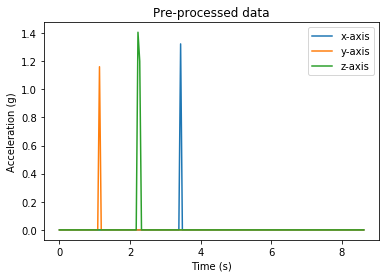

In [183]:
# Call your identify_axes function for the first dataset
identify_axes(X_g,Y_g,Z_g,[1,1,1])

# visualize the peaks you found for each axis
plt.plot(t1_list, X_g, label='x-axis')
plt.plot(t1_list, Y_g, label='y-axis')
plt.plot(t1_list, Z_g, label='z-axis')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Pre-processed data')
#plt.ylim([-1, 1])
plt.legend(fontsize=10)

XZY


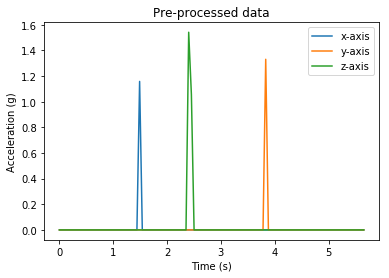

In [173]:
X_g2 = abs(adc_to_acceleration(x2_list)-baselineX)
Y_g2 = abs(adc_to_acceleration(y2_list)-baselineY)
Z_g2 = abs(adc_to_acceleration(z2_list)-baselineZ)
X_g2[X_g2<1.1] = 0
Y_g2[Y_g2<1] = 0
Z_g2[Z_g2<1] = 0

# Call your identify_axes function for the first dataset
identify_axes(X_g2,Y_g2,Z_g2,[1,1,1])

# visualize the peaks you found for each axis
plt.plot(t2_list, X_g2, label='x-axis')
plt.plot(t2_list, Y_g2, label='y-axis')
plt.plot(t2_list, Z_g2, label='z-axis')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Pre-processed data')
#plt.ylim([-1, 1])
plt.legend(fontsize=10)

ZXY


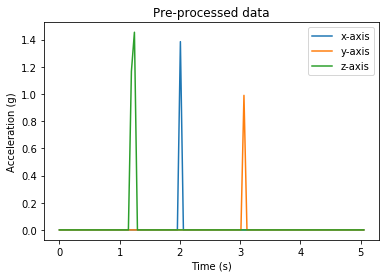

In [182]:
X_g3 = abs(adc_to_acceleration(x3_list)-baselineX)
Y_g3 = abs(adc_to_acceleration(y3_list)-baselineY)
Z_g3 = abs(adc_to_acceleration(z3_list)-baselineZ)
X_g3[X_g3<1.1] = 0
Y_g3[Y_g3<0.85] = 0
Z_g3[Z_g3<1] = 0

# Call your identify_axes function for the first dataset
identify_axes(X_g3,Y_g3,Z_g3,[1,0.9,1])

# visualize the peaks you found for each axis
plt.plot(t3_list, X_g3, label='x-axis')
plt.plot(t3_list, Y_g3, label='y-axis')
plt.plot(t3_list, Z_g3, label='z-axis')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Pre-processed data')
#plt.ylim([-1, 1])
plt.legend(fontsize=10)



## Appendix

### Source code of main.py

```python
'''ME224 Lab 4 starter code
Use this code as a starting point for
all lab 4 experiments.

Chen Chen 10/2018
'''

###############################################
############### Library Imports ###############
###############################################
import board
import time
from analogio import AnalogIn
from digitalio import DigitalInOut, Direction, Pull
from adafruit_dotstar import DotStar
from neopixel import NeoPixel
import gc
gc.collect()  # RAM garbage collection (or something)

###########################################################
############### Global Scope Initialization ###############
###########################################################

# Neopixel/dotstar colors [R, G, B]
COLOR_RED = [255, 0, 0]
COLOR_GREEN = [0, 255, 0]
COLOR_BLUE = [0, 0, 255]
COLOR_GRAY = [100, 100, 100]
COLOR_BLACK = [0, 0, 0]
# Initialize Neopixel and DotStar, comment out the one you don't need
neopixels = NeoPixel(board.D7, 1, brightness=0.1, auto_write=True)
dotstar = DotStar(board.APA102_SCK, board.APA102_MOSI,
                  1, brightness=0.25, auto_write=True)
# Accelerometer
x_axis = AnalogIn(board.A1)  # Accelerometer X axis
y_axis = AnalogIn(board.A2)  # Accelerometer Y axis
z_axis = AnalogIn(board.A3)  # Accelerometer X axis
# Button
button = DigitalInOut(board.D9)
button.direction = Direction.INPUT
button.pull = Pull.UP

####################################################
############### Function Definitions ###############
####################################################


def get_button():
    '''
    Reliably read the state of the button input

    If button pressed, it wait until the button is released and return True
    otherwise it return False
    '''
    if button.value is False:
        while button.value is False:
            pass
        if button.value is True:
            return True
    return False


def set_neopixel_color(color=[0, 0, 0]):
    '''
    Set the color of the neopixel/dotstar
    Comment out the one you are not using
    '''
    neopixels.fill(color)
    dotstar.fill(color)


def measurement_session(file_id=0, samp_fs=100, max_sample_time=10, print_to_file=False):
    '''
    Take continuous measurements and print to file
    The sampling process will end under two conditions
        1) either the button is pressed before max_sample_time is reached, or
        2) max_sample_time is reached
    '''
    set_neopixel_color(COLOR_GREEN)
    samp_dt = 1 / samp_fs
    num_samples = samp_fs * max_sample_time
    if print_to_file:
        try:
            fp = open("measurements_{0:02d}.txt".format(file_id), "w")
        except OSError:
            # if any file related error happens,
            # we will stop with the color set to red
            set_neopixel_color(COLOR_RED)
            while True:
                pass
    # start sampling
    # _ means ignore this parameter
    # in this case we need the for loop to run
    # num_samples times but don't need the index
    for _ in range(num_samples):
        time_sample = time.monotonic()
        sample = "{0:.5f}, {1:d}, {2:d}, {3:d}\n".format(
            time_sample, x_axis.value, y_axis.value, z_axis.value)
        # save or print data data
        if print_to_file:
            fp.write(sample)
        else:
            print(sample)
        while time.monotonic() < time_sample+samp_dt:
            # wait until the dt has passed whilt
            # keeping an eye on the button state
            if get_button():
                # if button pressed, finish writing the file
                # and return (ends this function)
                if print_to_file:
                    fp.close()
                return
    if print_to_file:
        # make sure the file is closed regardless
        # the button has been pressed or not
        fp.close()


#########################################
############### Main Loop ###############
#########################################

# Debug mode switch, if set to True
# then the program will go straight into
# continuous measurement and output mode
# where accelerations will be print directly
# to the serial so you can use the Mu Plotter
# to visualize the measurements
debug_mode = False

# Test file write access
# we will try to open a dummy file for writing
# if our board is in readonly mode, this will fail
# and blink_color will be set to RED and the neopixel/dotstar
# will blink in RED. If it works, that means
# we have enabled writing to file,
# then blink_color will be in GRAY
# and we should see neopixel/dotstar blink in GRAY
blink_color = COLOR_GRAY
try:
    with open("test.txt", "w") as fp:
        fp.close()
except:
    blink_color = COLOR_RED

# keep blink the light until button pressed for the first time
while get_button() is False:
    time.sleep(0.2)
    set_neopixel_color(COLOR_BLACK)
    time.sleep(0.2)
    set_neopixel_color(blink_color)
    if debug_mode:
        break

# Wait for 1 second before taking reference measurements
save_file = not debug_mode
if save_file:
    time.sleep(1)
    measurement_session(0, samp_fs=20, max_sample_time=1,
                        print_to_file=save_file)

# Start main loop
file_id = 1
while True:
    if debug_mode:
        set_neopixel_color(COLOR_BLUE)
        # debug mode, take measurement and output to Plotter
        print((x_axis.value, y_axis.value, z_axis.value))
        time.sleep(0.01)
    else:
        # non-debug mode, start sampling when button is pressed
        if get_button():
            measurement_session(file_id, samp_fs=20,
                                max_sample_time=60, print_to_file=save_file)
            file_id += 1
        else:
            set_neopixel_color(COLOR_GRAY)
```